# Multi-label Text Classification - Machine Learning Models

#### Imports

In [91]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional

from wordcloud import WordCloud 
import wordcloud
from PIL import Image

from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression

from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.model_selection import iterative_train_test_split

#### Variable declarations:

In [2]:
np.random.seed(1234)   # To get the same result every time
random_rows = 5000     # number of rows to read from the csv file
max_seq_length = 300   # Maximum comment size
max_words = 50000      # Maximum vocabulary (word) size
embed_dim = 300        # Maximum Embedding Dimension

## 1) LOAD DATA

### Reading the Input File:

In [3]:
df = pd.read_csv('train.csv', encoding = "ISO-8859-1", nrows = random_rows) #, usecols = range(0,4), nrows = random_rows)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
len(df)

5000

#### Finding the number of Unlabelled comments :

In [5]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) 
             & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8924


#### Finding if the comments column has any null values:

In [6]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

#### Fixing the short forms/word contractions:

In [7]:
expansion_list = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have",
    "https": " ",
    "co": " ",
    "the": " ",
    "it": " "
}

word_expansions = re.compile('(%s)' % '|'.join(expansion_list.keys()))

def expandContractions(text, c_re=word_expansions):
    def replace(match):
        return expansion_list[match.group(0)]
    return word_expansions.sub(replace, text)

#### Data Pre-Processing/Data Cleansing :

In [8]:
def text_cleaning(comment_text):
    cleaned_text = []
    for text in comment_text:
        text = str(text)
        
        # Tokenization and removal of stop words :
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(text) 
        sent = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(sent)

        # Removing all hashtags and @mentions
        text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|[^a-zA-Z]", " ", text).split())
        text = ' '.join([w for w in text.split() if len(w)>3])
      
        # Lemmatization to generalize the words :
        lemmatizer = WordNetLemmatizer()
        sentence = [lemmatizer.lemmatize(word) for word in text]
        text = ''.join(sentence)

        cleaned_text.append(text)

    return cleaned_text

In [9]:
text_arr = [x for x in df['comment_text']]
text_arr[:2]
type(text_arr[0])

str

#### Calling the Data pre-processing function :

In [10]:
X_text = text_cleaning(text_arr)

#### Reading the first 5 comments after data pre-processing :

In [11]:
X_text[:5]

['Explanation edits made username Hardcore Metallica reverted They vandalisms closure voted York Dolls please remove template talk page since retired',
 'matches background colour seemingly stuck Thanks talk January',
 'really trying edit constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'More make real suggestions improvement wondered section statistics later subsection types accidents think references need tidying exact format date format later else first preferences formatting style references want please know There appears backlog articles review guess delay reviewer turns listed relevant form Wikipedia Good article nominations Transport',
 'hero chance remember page']

In [12]:
len(X_text)

5000

#### Finding out the most commonly used words in the comments :

In [13]:
data_set = ' '.join(x for x in X_text)
split_data = data_set.split()
counter_variable = Counter(split_data)
  
# input values and their respective counts.
most_occur = counter_variable.most_common(10)
  
print(most_occur)

[('article', 1741), ('page', 1470), ('Wikipedia', 1179), ('would', 981), ('like', 941), ('talk', 867), ('think', 607), ('know', 600), ('edit', 549), ('This', 522)]


#### Plotting the most commonly used words in the comments :

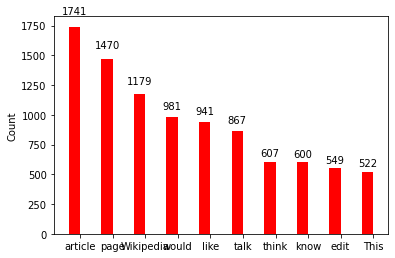

In [14]:
names, values = zip(*most_occur)  
ind = np.arange(len(most_occur))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, values, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(names)



def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)

plt.show()

#### Finding out the number of comments available for each category :

In [15]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,503
1,severe_toxic,51
2,obscene,270
3,threat,20
4,insult,271
5,identity_hate,49


Text(0.5, 0, 'category')

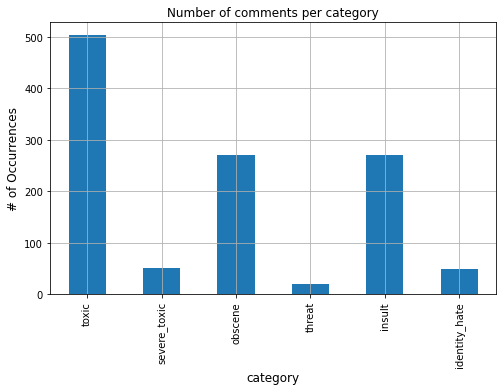

In [16]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

#### Observations : The dataset is very imbalanced.

In [17]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#####  Word Cloud  (For negative sentiments)

In [135]:
image_mask = np.array(Image.open("emoji1.png"))

In [141]:
# Create a word cloud image
wc = WordCloud(background_color="black", max_words=300, mask=image_mask, #stopwords=stopwords,
               contour_width=1, contour_color='grey')

In [142]:
# Generate a wordcloud
text = ' '.join(review for review in X_text)
wc.generate(text)

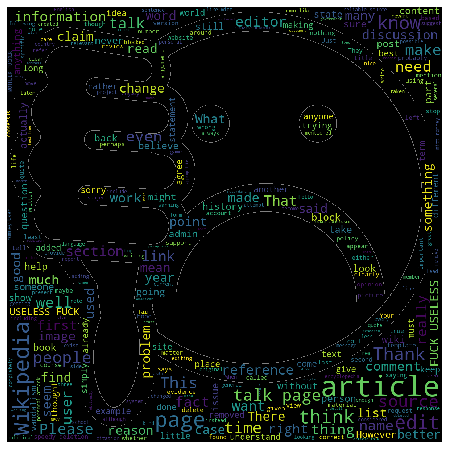

In [143]:
# show
plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='nearest')
plt.axis("off")
plt.show()   

### Getting the Vector- representations of words (converting words into numbers) , in order to feed it to the ML Models :

### Tokenization


##### Sentence Tokenization - Generating vocabulary index dictionaries based on word frequency. Every word in the sentence is given a unique number:

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)

##### tokenizer.texts_to_sequences -> Transforms the above texts into a sequence of integers:

In [19]:
X_text_to_seq = tokenizer.texts_to_sequences(X_text)

In [20]:
len(X_text_to_seq)

5000

##### Word Index:

In [21]:
word_index = tokenizer.word_index
print('Total number of unique tokens = %s ' % len(word_index))

Total number of unique tokens = 21293 


In [22]:
X = pad_sequences(X_text_to_seq, maxlen=max_seq_length)

print('Shape of data_depressive tensor:', X.shape)


Shape of data_depressive tensor: (5000, 300)


#### Printing the Array after transforming the text into integers :

In [23]:
X[:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

#### Word-Embeddings:

#### In order to derive the Vector representations of the words in our comments column, we will be using Google's pre-trained model called word2vector.
* For every word, we will look up its corresponding vector representation from word2vec and load it into the embedding_matrix, as shown below:

In [24]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [25]:
words = min(max_words+1, len(word_index)+1)

embedding_matrix = np.zeros((words, embed_dim))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < max_words:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [26]:
print(len(X))

5000


In [27]:
print(len(embedding_matrix))

21294


In [28]:
embedding_matrix.shape

(21294, 300)

In [29]:
X.shape

(5000, 300)

#### Labels (Target variables)

In [30]:
category_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[category_list]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
4995,0,0,0,0,0,0
4996,0,0,0,0,0,0
4997,1,0,0,0,1,0
4998,0,0,0,0,0,0


#### Converting the labels into an Array:

In [31]:
labels = np.array(df[category_list])
labels[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [32]:
X

array([[    0,     0,     0, ...,     2,    50,  3143],
       [    0,     0,     0, ...,    17,     4,   922],
       [    0,     0,     0, ...,  2605,   439,   336],
       ...,
       [    0,     0,     0, ...,  9066,   684,  1143],
       [    0,     0,     0, ...,   113,  7037,   576],
       [    0,     0,     0, ...,   314,   260, 21293]])

In [33]:
len(X)

5000

In [34]:
y = labels
len(y)

5000

####  MultiLabelBinarizer() : Used in the case of Multi-label classifications 

In [65]:
binarizer = MultiLabelBinarizer()
train_labels = binarizer.fit_transform(X)
test_labels = binarizer.transform(y)

In [66]:
X.shape

(5000, 300)

In [67]:
y.shape

(5000, 6)

#### Data Splitting into Training & Testing datasets :

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

#### Checking the length of the Train/Test datasets:

In [69]:
len(X_train)

3500

In [70]:
len(y_train)

3500

In [71]:
len(X_test)

1500

In [72]:
len(y_test)

1500

#### Checking the shape of the Train/Test datasets:

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3500, 300)
(3500, 6)
(1500, 300)
(1500, 6)


In [75]:
X_train[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [76]:
y_train[:1]

array([[0, 0, 0, 0, 0, 0]], dtype=int64)

### Model 1: Baseline Model -> Multinomial Naive Bayes Classifier

* Multinomial Naive Bayes considers a feature vector with its frequency i.e., represents the number of times it appears in the data.

In [77]:
naive_model = OneVsRestClassifier(MultinomialNB())
naive_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [78]:
naive_pred = naive_model.predict(X_test)
print(classification_report(y_test, naive_pred))

              precision    recall  f1-score   support

           0       0.11      0.87      0.20       149
           1       0.00      0.25      0.01         8
           2       0.06      0.76      0.12        78
           3       0.01      1.00      0.02         7
           4       0.07      0.87      0.13        83
           5       0.01      0.87      0.02        15

   micro avg       0.05      0.83      0.10       340
   macro avg       0.04      0.77      0.08       340
weighted avg       0.08      0.83      0.15       340
 samples avg       0.04      0.09      0.05       340



#### 1. Accuracy - Accuracy is the most widely used performance metric and is simply defined as the ratio of correctly predicted observations to the total number of observations.
* Accuracy = TP+TN/TP+FP+FN+TN

#### 2. Precision - Precision is basically the ratio of True Positives to the total predicted positive observations. 
* Precision = TP/TP+FP
#### With the help of Precision, we can answer the below question - 
#### Of all the toxic text classified, how many were really related to toxic categories? High precision value relates to a low false positive rate. 


#### 3. Recall - Recall is basically the ratio of True Positives to all observations in the True class. 
* Recall = TP/TP+FN
#### With the help of Recall, we can answer the below question - 
####  Of all the classified text, how many have been correctly classified by our Model? High precision value relates to a low false positive rate. 

In [79]:
print ("Accuracy is", metrics.accuracy_score(y_test,naive_pred))
print ("Precison is", metrics.precision_score(y_test,naive_pred, average='micro'))
print ("Recall is", metrics.recall_score(y_test,naive_pred, average='micro'))

Accuracy is 0.17333333333333334
Precison is 0.05125408942202835
Recall is 0.8294117647058824


#### Observations :
* The Multinomial Naive Bayes Classifier has very poor Accuracy and Precision metrics. 
* However, the Recall seems to be good (82%).

### Model 2: Decision Tree Classifier

* Decision Trees are basically a type of Supervised Machine Learning i.e., the input as well as the corresponding output in the training data is explained to the model and the data keeps getting continuously split based on a particular parameter.

In [80]:
model1 = DecisionTreeClassifier(criterion="entropy", max_depth=3)
model1.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [81]:
#Test
y_pred = model1.predict(X_test)

In [82]:
y_pred[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [83]:
#Compare real and test
print("Real labels: ", y_test)

print("Predicted labels: ", y_pred)

Real labels:  [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
Predicted labels:  [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### Performance Metrics :
#### For Multi-label classification, we need to specify the average parameter as "macro":

In [88]:
#Apply Accuracy_score for checking accuracy

print ("Accuracy is", metrics.accuracy_score(y_test,y_pred))
print ("Precison is", metrics.precision_score(y_test,y_pred, average='macro'))
print ("Recall is", metrics.recall_score(y_test,y_pred, average='macro'))

Accuracy is 0.8906666666666667
Precison is 0.05555555555555555
Recall is 0.0011185682326621924


#### Confusion Matrix :

In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.33      0.01      0.01       149
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        78
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        83
           5       0.00      0.00      0.00        15

   micro avg       0.14      0.00      0.01       340
   macro avg       0.06      0.00      0.00       340
weighted avg       0.15      0.00      0.01       340
 samples avg       0.00      0.00      0.00       340



### Model 3: LabelPowerset()

In [92]:
model_powerSetSVC = LabelPowerset(LogisticRegression())
model_powerSetSVC.fit(X_train, y_train)

LabelPowerset(classifier=LogisticRegression(), require_dense=[True, True])

In [93]:
powerSet_pred = model_powerSetSVC.predict(X_test)

In [96]:
print("Accuracy = ",accuracy_score(y_test,powerSet_pred))
print("F1 score = ",f1_score(y_test,powerSet_pred, average="micro"))
print ("Precison is", metrics.precision_score(y_test,powerSet_pred, average='micro'))
print ("Recall is", metrics.recall_score(y_test,powerSet_pred, average='micro'))

Accuracy =  0.8526666666666667
F1 score =  0.011695906432748537
Precison is 0.017341040462427744
Recall is 0.008823529411764706


## Model 4 : Multi-label deep learning with scikit-multilearn

In [111]:
X_train.shape[1]

300

In [112]:
y_train.shape[1]

6

### Specifying Input and Output dimensions :

In [113]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

### Sequential Model creation : Keras Classifier with a Single class

In [114]:
from keras.models import Sequential
from keras.layers import Dense

def create_model_single_class(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [120]:
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.ext import Keras

KERAS_PARAMS = dict(epochs=3, batch_size=100, verbose=0)

clf = BinaryRelevance(classifier=Keras(create_model_single_class, False, KERAS_PARAMS), require_dense=[True,True])

In [122]:
type(X_train)

numpy.ndarray

### Convert the numpy array to Tensor and fit the model (i.e., Model Training) :

In [123]:
clf.fit(tf.convert_to_tensor(X_train, dtype=tf.float32), y_train)


BinaryRelevance(classifier=Keras(build_function=<function create_model_single_class at 0x000001AC3221C708>,
                                 keras_params={'batch_size': 100, 'epochs': 3,
                                               'verbose': 0}),
                require_dense=[True, True])

### Model predictions :

In [124]:
result = clf.predict(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


### Multi-class Keras Classifier:

In [127]:
def create_model_multiclass(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [129]:
from skmultilearn.problem_transform import LabelPowerset
clf = LabelPowerset(classifier=Keras(create_model_multiclass, True, KERAS_PARAMS), require_dense=[True,True])
clf.fit(tf.convert_to_tensor(X_train, dtype=tf.float32), y_train)


LabelPowerset(classifier=Keras(build_function=<function create_model_multiclass at 0x000001ADAE022168>,
                               keras_params={'batch_size': 100, 'epochs': 3,
                                             'verbose': 0},
                               multi_class=True),
              require_dense=[True, True])

In [130]:
y_pred_LPS = clf.predict(X_test)

In [132]:
y_pred_LPS.shape

(1500, 6)

In [133]:
print(classification_report(y_test,y_pred_LPS))

              precision    recall  f1-score   support

           0       0.09      0.66      0.16       149
           1       0.01      0.38      0.01         8
           2       0.04      0.38      0.07        78
           3       0.00      0.00      0.00         7
           4       0.05      0.64      0.10        83
           5       0.01      0.27      0.01        15

   micro avg       0.05      0.56      0.08       340
   macro avg       0.03      0.39      0.06       340
weighted avg       0.06      0.56      0.11       340
 samples avg       0.05      0.06      0.05       340



In [134]:
print("Accuracy = ",accuracy_score(y_test,y_pred_LPS))
print("F1 score = ",f1_score(y_test,y_pred_LPS, average="micro"))
print ("Precison is", metrics.precision_score(y_test,y_pred_LPS, average='micro'))
print ("Recall is", metrics.recall_score(y_test,y_pred_LPS, average='micro'))

Accuracy =  0.064
F1 score =  0.08422459893048129
Precison is 0.04556412729026037
Recall is 0.5558823529411765
